In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-02-13 11:35:22.366715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

In [3]:
# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

In [4]:
def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

## Validate the model with the dataset collected again in same phone

## iPhone14Pro_I

In [5]:
class_label = 10
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Smartphones/EM_Signals/iPhone14-Pro/iPhone14_pro_I(ii)/"
    if(i==0):
        data = getData(folder_path + "calendar-app.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "camera-photo.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "camera-video.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "email-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "gallery-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "home-screen.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "idle.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "phone-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==8):
            data = getData(folder_path + "sms-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==9):
            data = getData(folder_path + "web_browser-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I_BeSh.csv', header=False)

[0.0078125+0.0078125j 0.03125  -0.0078125j 0.015625 +0.0078125j ...
 0.015625 +0.015625j  0.015625 +0.j        0.03125  -0.0078125j]
2048
84337
(2048, 84337)
[0.02120258 0.01093484 0.00379057 ... 0.00193539 0.0039011  0.01052333]
0
(10000, 2048)
(10000,)
[0.015625 +0.j        0.0234375+0.0078125j 0.0078125+0.j        ...
 0.0078125-0.0078125j 0.0234375+0.015625j  0.015625 +0.0078125j]
2048
83238
(2048, 83238)
[0.01855624 0.00968533 0.00359719 ... 0.00189885 0.00373283 0.00970302]
1
(20000, 2048)
(20000,)
[0.015625 +0.0078125j 0.015625 +0.0078125j 0.       +0.0078125j ...
 0.0234375+0.0078125j 0.015625 +0.0078125j 0.015625 +0.015625j ]
2048
80509
(2048, 80509)
[0.01902401 0.0098836  0.00327027 ... 0.00165634 0.00325221 0.00979596]
2
(30000, 2048)
(30000,)
[0.       +0.0078125j 0.03125  +0.j        0.015625 +0.03125j   ...
 0.015625 -0.0078125j 0.0234375+0.015625j  0.0078125+0.j       ]
2048
85214
(2048, 85214)
[0.01858882 0.00984553 0.00361264 ... 0.00206463 0.00381185 0.00977849]
3
(40

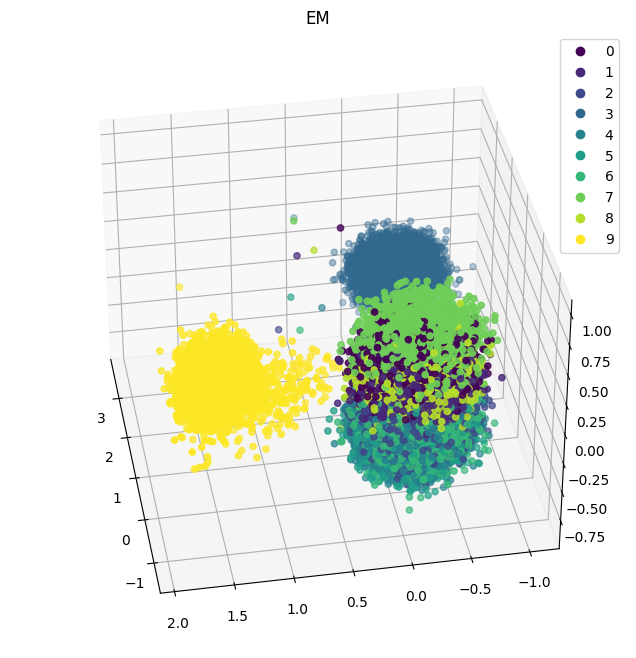

In [6]:
from sklearn.decomposition import PCA

def plot_3d(signal, plot_name, colors, labels, out_path):
    pca = PCA(n_components=3)
    pca_data =pd.DataFrame(pca.fit_transform(signal))
    # visualize in 3d
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    scatter =ax.scatter(pca_data[0],pca_data[1],pca_data[2], c=colors)
    ax.view_init(elev=35, azim=170)
    ax.legend(handles=scatter.legend_elements()[0], loc="best", labels=labels);
    ax.set_title(plot_name);
    plt.savefig(out_path)

# EM scatter
data = em_data
labels = data['labels']
data = data.drop(columns=['labels'])
data = data.dropna(axis='columns')
unique_labels = labels.unique()
labels2colors = {}
classes = []
for i,unique_label in enumerate(unique_labels):
    labels2colors[unique_label] = i
    classes.append(unique_label)
colors = [labels2colors[label] for label in labels]
plot_3d(data,"EM", colors, classes,f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/i14Pro_new_scatter.pdf')

Check the new samples of iPhone14Por_I with olde model 

In [7]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/iPHONE14Pro_I_model.h5")

2023-02-13 12:06:24.659064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 16s 5ms/step - loss: 6.6274 - accuracy: 0.1224
test loss, test acc: [6.627435684204102, 0.12240000069141388]


In [9]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

3125/3125 [==============================] - 13s 4ms/step
[7 0 7 ... 9 8 8]
7


In [10]:
print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

[[2492  679 1934 2565    1    0  397 1599  171  162]
 [1487 1169 1988 1197    0    0  721 2424  666  348]
 [ 498 2609  852  219    3    0 1926  455 1519 1919]
 [   4  314   57    0    1    5 2681   39 2042 4857]
 [ 614 2673  756  347    2    0 1880  825 1519 1384]
 [ 462 2062 1232  183    5    0 1988  491 1730 1847]
 [ 487 2258  851  182    1    1 1591  593 2305 1731]
 [2914  596 1689 2341    1    0  266 1820  143  230]
 [1561 1227 1883 1548    0    0  789 1909  540  543]
 [ 353 1654  229   91    1   16 1874  409 1599 3774]]
              precision    recall  f1-score   support

           0       0.23      0.25      0.24     10000
           1       0.08      0.12      0.09     10000
           2       0.07      0.09      0.08     10000
           3       0.00      0.00      0.00     10000
           4       0.13      0.00      0.00     10000
           5       0.00      0.00      0.00     10000
           6       0.11      0.16      0.13     10000
           7       0.17      0.18   

Test Accuracy:0.1224


Text(0.5, 1.0, 'Accuracy:0.122')

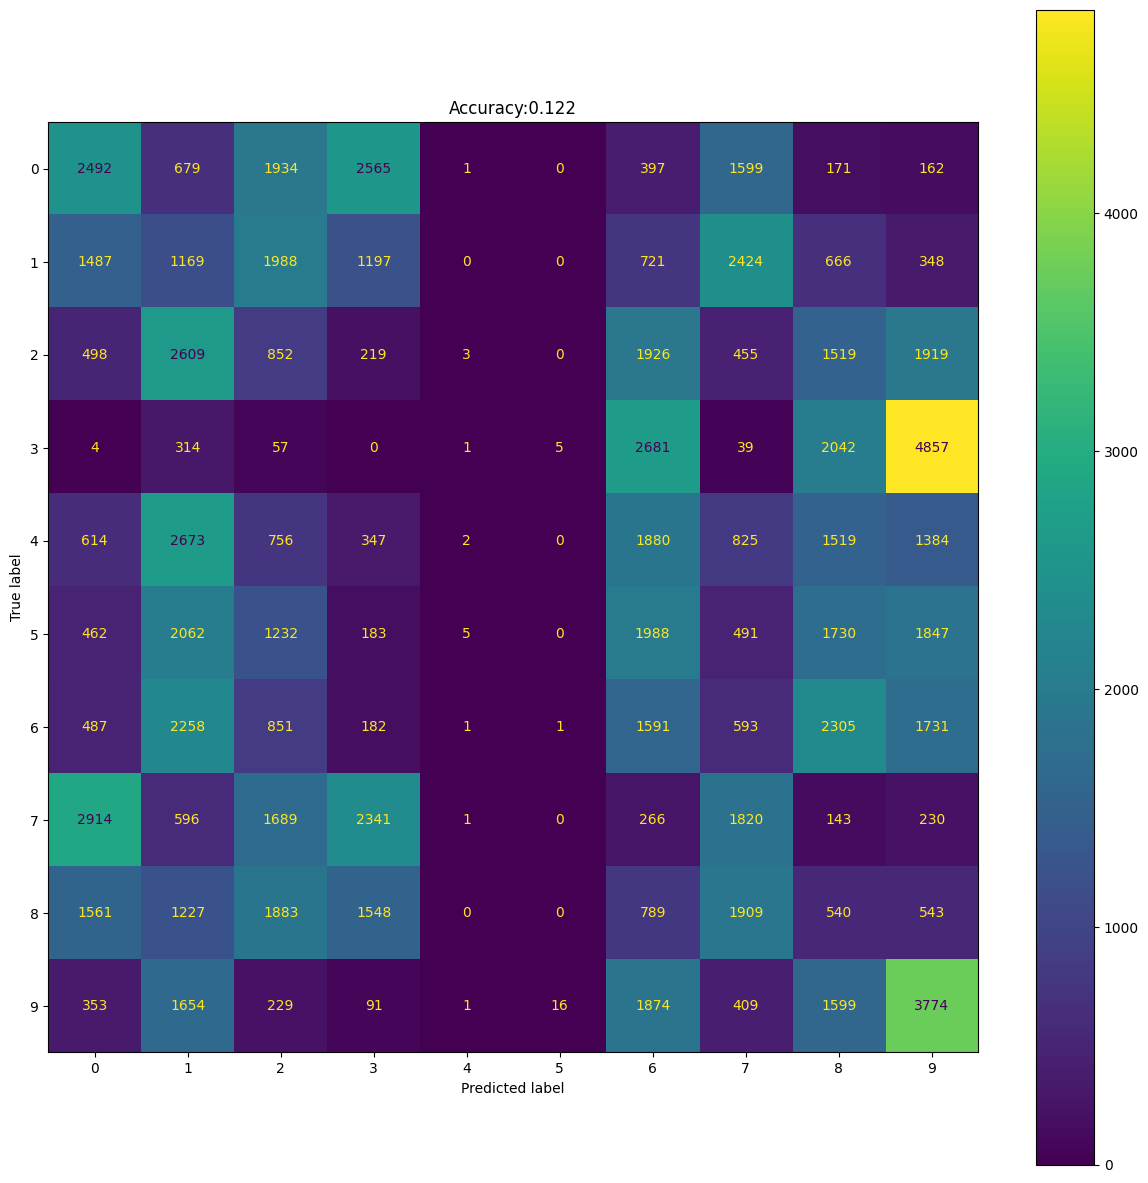

In [11]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_combined/iPhone13_II&III_confusion_matrix.pdf')

## Apply transfer learning for the samples by only training the output layer

In [10]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/iPHONE14Pro_I_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 4,511,210
Non-

In [11]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 1,010
Non-trai

In [12]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
history = model.fit(X, Y, epochs=25)

Epoch 1/25
3125/3125 [==============================] - 15s 5ms/step - loss: 3.4545 - accuracy: 0.1628
Epoch 2/25
3125/3125 [==============================] - 15s 5ms/step - loss: 1.9930 - accuracy: 0.2705
Epoch 3/25
3125/3125 [==============================] - 15s 5ms/step - loss: 1.7631 - accuracy: 0.3135
Epoch 4/25
3125/3125 [==============================] - 13s 4ms/step - loss: 1.7012 - accuracy: 0.3344
Epoch 5/25
3125/3125 [==============================] - 13s 4ms/step - loss: 1.6744 - accuracy: 0.3461
Epoch 6/25
3125/3125 [==============================] - 19s 6ms/step - loss: 1.6585 - accuracy: 0.3529
Epoch 7/25
3125/3125 [==============================] - 15s 5ms/step - loss: 1.6474 - accuracy: 0.3576
Epoch 8/25
3125/3125 [==============================] - 14s 5ms/step - loss: 1.6388 - accuracy: 0.3621
Epoch 9/25
3125/3125 [==============================] - 12s 4ms/step - loss: 1.6323 - accuracy: 0.3649
Epoch 10/25
3125/3125 [==============================] - 14s 5ms/step - l

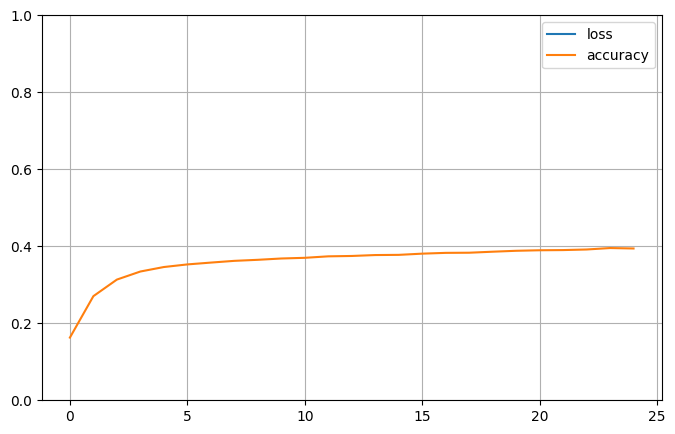

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Test the accuracy

In [15]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 14s 4ms/step - loss: 1.5722 - accuracy: 0.3967
test loss, test acc: [1.5721852779388428, 0.3967199921607971]


In [16]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

3125/3125 [==============================] - 14s 4ms/step
[7 0 1 ... 9 6 9]
7


In [17]:
print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

[[3723 1403  290    0  158  135  179 2847 1179   86]
 [1289 3528  424   13  394  488  780 1367 1421  296]
 [ 309  753 3017  253  727 1165 2049  108  570 1049]
 [   0    1   34 8772   38  208  113    0    2  832]
 [ 315 1154 1464  189 1464  993 1963  199  795 1464]
 [ 230  882 1567  329  571 2297 2198  118  612 1196]
 [ 160  915 1510  302  736 1339 3218  109  535 1176]
 [2280 1225  254    2  151  104  192 4547 1137  108]
 [1467 2209  528   10  438  391  710 1550 2314  383]
 [  35  244  375  924  329  529  548   50  174 6792]]
              precision    recall  f1-score   support

           0       0.38      0.37      0.38     10000
           1       0.29      0.35      0.32     10000
           2       0.32      0.30      0.31     10000
           3       0.81      0.88      0.84     10000
           4       0.29      0.15      0.20     10000
           5       0.30      0.23      0.26     10000
           6       0.27      0.32      0.29     10000
           7       0.42      0.45   

Test Accuracy:0.39672


Text(0.5, 1.0, 'Accuracy:0.397')

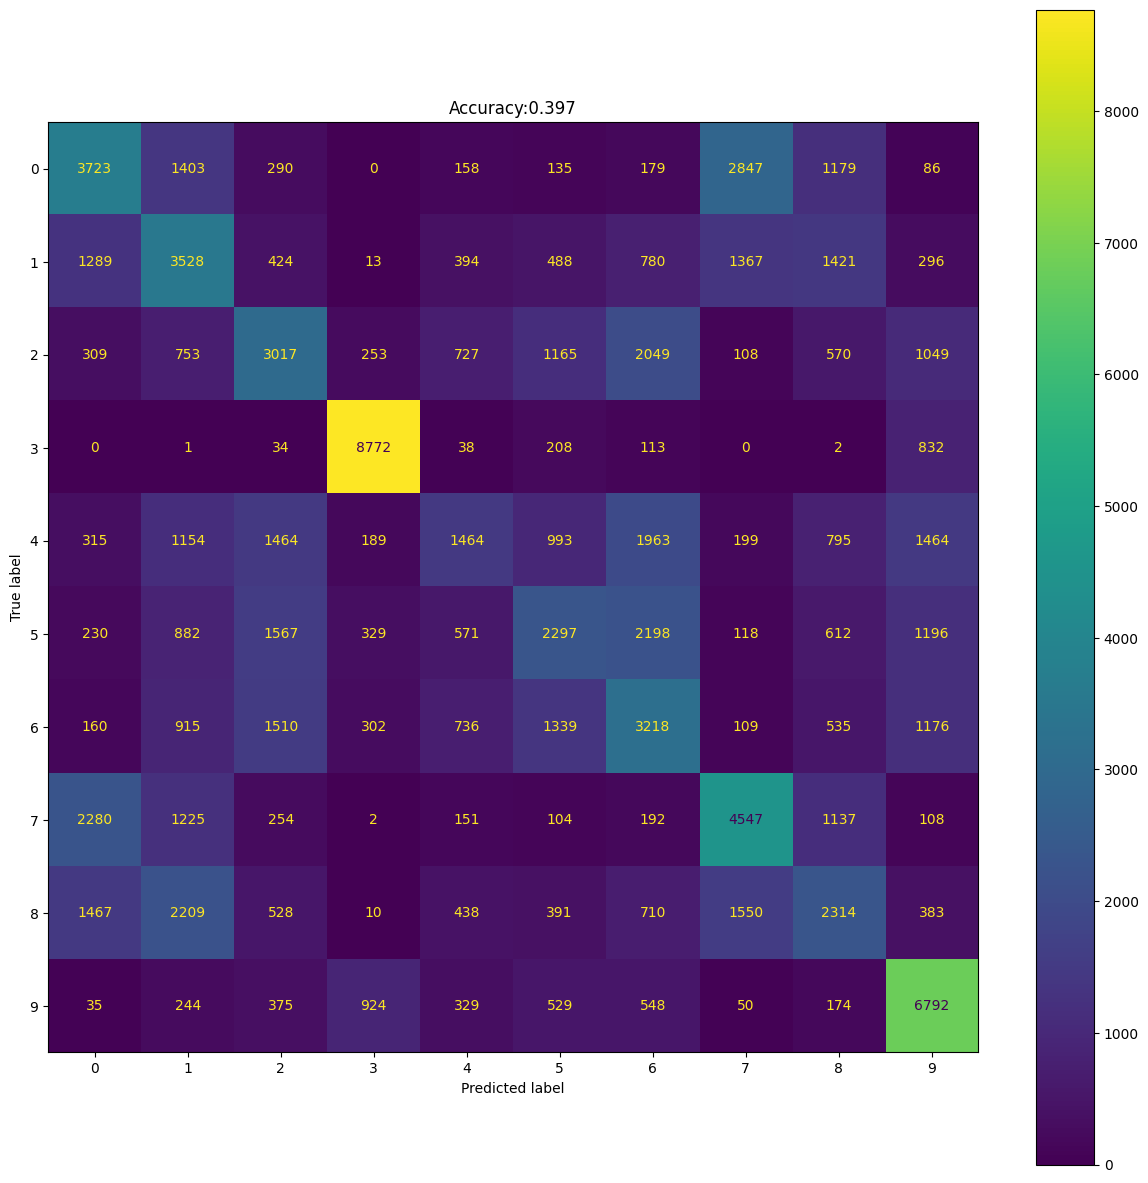

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_combined/iPhone13_II&III_confusion_matrix.pdf')

## new sample Own model

## Besh Model

Create an own model of newly collected samples of iPhone6S_I_BeSh by trainig the whole dataset for validate the time of training and accuracy level 

In [5]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(feature_vector_size,)))
model.add(keras.layers.Dense(1400, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 4,511,210
Non-

2022-10-12 14:00:50.635497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [8]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/iPHONE6S_I_BeSh_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=25, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/25
2532/2532 [==============================] - 23s 9ms/step - loss: 2.0866 - accuracy: 0.2636 - val_loss: 1.7796 - val_accuracy: 0.4509
Epoch 2/25
2532/2532 [==============================] - 24s 10ms/step - loss: 1.3859 - accuracy: 0.6535 - val_loss: 1.0443 - val_accuracy: 0.7438
Epoch 3/25
2532/2532 [==============================] - 24s 9ms/step - loss: 0.7524 - accuracy: 0.8097 - val_loss: 0.5287 - val_accuracy: 0.8642
Epoch 4/25
2532/2532 [==============================] - 30s 12ms/step - loss: 0.3759 - accuracy: 0.9080 - val_loss: 0.2571 - val_accuracy: 0.9427
Epoch 5/25
2532/2532 [==============================] - 26s 10ms/step - loss: 0.1765 - accuracy: 0.9657 - val_loss: 0.1170 - val_accuracy: 0.9797
Epoch 6/25
2532/2532 [==============================] - 26s 10ms/step - loss: 0.0916 - accuracy: 0.9849 - val_loss: 0.0681 - val_accuracy: 0.9892
Epoch 7/25
2532/2532 [==============================] - 25s 10ms/step - loss: 0.0575 - accuracy: 0.9906 - val_loss: 0.0485 - v

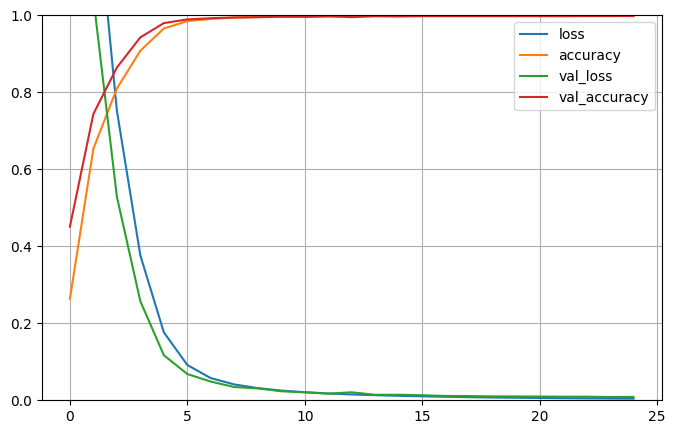

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Test the Own iPhone6S_I_BeSh Model

In [10]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/iPHONE6S_I_BeSh_model.h5")

In [11]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

313/313 [==============================] - 2s 5ms/step - loss: 0.0093 - accuracy: 0.9975
test loss, test acc: [0.009289531968533993, 0.9975000023841858]


In [12]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_pred)
print(y_pred[0])

313/313 [==============================] - 1s 4ms/step
[0 6 5 ... 5 5 6]
0


In [13]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1008    0    1    0    1    0    0    1    0    0]
 [   0 1008    2    0    0    0    0    0    0    0]
 [   2    0  985    0    2    0    1    3    0    0]
 [   0    0    0  939    0    0    0    0    0    0]
 [   1    3    0    0 1038    0    1    0    0    0]
 [   0    0    0    0    0 1027    0    0    0    0]
 [   0    0    0    0    1    0  997    1    0    0]
 [   3    0    2    0    0    0    0  969    0    0]
 [   0    0    0    0    0    0    0    0 1003    0]
 [   0    0    0    0    0    0    0    0    0 1001]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1011
         1.0       1.00      1.00      1.00      1010
         2.0       0.99      0.99      0.99       993
         3.0       1.00      1.00      1.00       939
         4.0       1.00      1.00      1.00      1043
         5.0       1.00      1.00      1.00      1027
         6.0       1.00      1.00      1.00       999
         7.0       0.99      0.99   